# Amazon Reviews

Amazon reviews data obtained via [UCSD](http://jmcauley.ucsd.edu/data/amazon/) – working with 5-core data for Toys and Games.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import spacy
from nltk.corpus import stopwords
from collections import Counter
from sklearn.naive_bayes import BernoulliNB

raw_data = pd.read_json('./data/toys.json', lines=True)
print(raw_data.shape[0], 'Rows')
print(raw_data.shape[1], 'Columns\n')

for rating in sorted(raw_data['overall'].unique()):
    num_ratings = raw_data[raw_data['overall'] == rating].shape[0]
    print(rating, '-', num_ratings, ';', round(num_ratings/raw_data.shape[0]*100, 2), '%')
raw_data.head()

167597 Rows
9 Columns

1 - 4707 ; 2.81 %
2 - 6298 ; 3.76 %
3 - 16357 ; 9.76 %
4 - 37445 ; 22.34 %
5 - 102790 ; 61.33 %


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0439893577,"[0, 0]",5,I like the item pricing. My granddaughter want...,"01 29, 2014",A1VXOAVRGKGEAK,Angie,Magnetic board,1390953600
1,0439893577,"[1, 1]",4,Love the magnet easel... great for moving to d...,"03 28, 2014",A8R62G708TSCM,Candace,it works pretty good for moving to different a...,1395964800
2,0439893577,"[1, 1]",5,Both sides are magnetic. A real plus when you...,"01 28, 2013",A21KH420DK0ICA,capemaychristy,love this!,1359331200
3,0439893577,"[0, 0]",5,Bought one a few years ago for my daughter and...,"02 8, 2014",AR29QK6HPFYZ4,dcrm,Daughters love it,1391817600
4,0439893577,"[1, 1]",4,I have a stainless steel refrigerator therefor...,"05 5, 2014",ACCH8EOML6FN5,DoyZ,Great to have so he can play with his alphabet...,1399248000


In [2]:
df = raw_data.drop(columns=['reviewerName', 'reviewTime'], axis=1)

for col in df.columns:
    if col != 'helpful':
        print(col, '-', len(df[col].unique()), 'unique vals;', df[col].dtype)
    else:
        print(col + ';', df[col].dtype)

asin - 11924 unique vals; object
helpful; object
overall - 5 unique vals; int64
reviewText - 167490 unique vals; object
reviewerID - 19412 unique vals; object
summary - 126788 unique vals; object
unixReviewTime - 4119 unique vals; int64


In [3]:
df['overall'] = ['low' if rating < 5 else 'high' for rating in df['overall']]

In [4]:
df['Year'] = pd.to_datetime(df['unixReviewTime'], unit='s').apply(lambda x: x.year)
df['Month'] = pd.to_datetime(df['unixReviewTime'], unit='s').apply(lambda x: x.month)
df['Day'] = pd.to_datetime(df['unixReviewTime'], unit='s').apply(lambda x: x.day)
df['Hour'] = pd.to_datetime(df['unixReviewTime'], unit='s').apply(lambda x: x.hour)

print('unique years:', sorted(df['Year'].unique()))
print('unique months:', sorted(df['Month'].unique()))
print('unique days:', sorted(df['Day'].unique()))
print('unique hours:', sorted(df['Hour'].unique()))
df.head()

unique years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
unique months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
unique days: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
unique hours: [0]


,asin,helpful,overall,reviewText,reviewerID,summary,unixReviewTime,Year,Month,Day,Hour
0,0439893577,"[0, 0]",high,I like the item pricing. My granddaughter want...,A1VXOAVRGKGEAK,Magnetic board,1390953600,2014,1,29,0
1,0439893577,"[1, 1]",low,Love the magnet easel... great for moving to d...,A8R62G708TSCM,it works pretty good for moving to different a...,1395964800,2014,3,28,0
2,0439893577,"[1, 1]",high,Both sides are magnetic. A real plus when you...,A21KH420DK0ICA,love this!,1359331200,2013,1,28,0
3,0439893577,"[0, 0]",high,Bought one a few years ago for my daughter and...,AR29QK6HPFYZ4,Daughters love it,1391817600,2014,2,8,0
4,0439893577,"[1, 1]",low,I have a stainless steel refrigerator therefor...,ACCH8EOML6FN5,Great to have so he can play with his alphabet...,1399248000,2014,5,5,0


In [5]:
def get_helpfulness(helpful_list):
    return 0 if helpful_list[1] == 0 else helpful_list[0] / helpful_list[1]

df['helpful_votes'] = [helpful_list[0] for helpful_list in df['helpful']]
df['unhelpful_votes'] = [helpful_list[1] - helpful_list[0] for helpful_list in df['helpful']]
df['total_votes'] = [helpful_list[1] for helpful_list in df['helpful']]
df['helpfulness'] = [get_helpfulness(helpful_list) for helpful_list in df['helpful']]
df = df.drop(columns=['unixReviewTime', 'Hour', 'helpful'])
df.head()

,asin,overall,reviewText,reviewerID,summary,Year,Month,Day,helpful_votes,unhelpful_votes,total_votes,helpfulness
0,0439893577,high,I like the item pricing. My granddaughter want...,A1VXOAVRGKGEAK,Magnetic board,2014,1,29,0,0,0,0.0
1,0439893577,low,Love the magnet easel... great for moving to d...,A8R62G708TSCM,it works pretty good for moving to different a...,2014,3,28,1,0,1,1.0
2,0439893577,high,Both sides are magnetic. A real plus when you...,A21KH420DK0ICA,love this!,2013,1,28,1,0,1,1.0
3,0439893577,high,Bought one a few years ago for my daughter and...,AR29QK6HPFYZ4,Daughters love it,2014,2,8,0,0,0,0.0
4,0439893577,low,I have a stainless steel refrigerator therefor...,ACCH8EOML6FN5,Great to have so he can play with his alphabet...,2014,5,5,1,0,1,1.0


11924 unique products
19412 unique reviewers


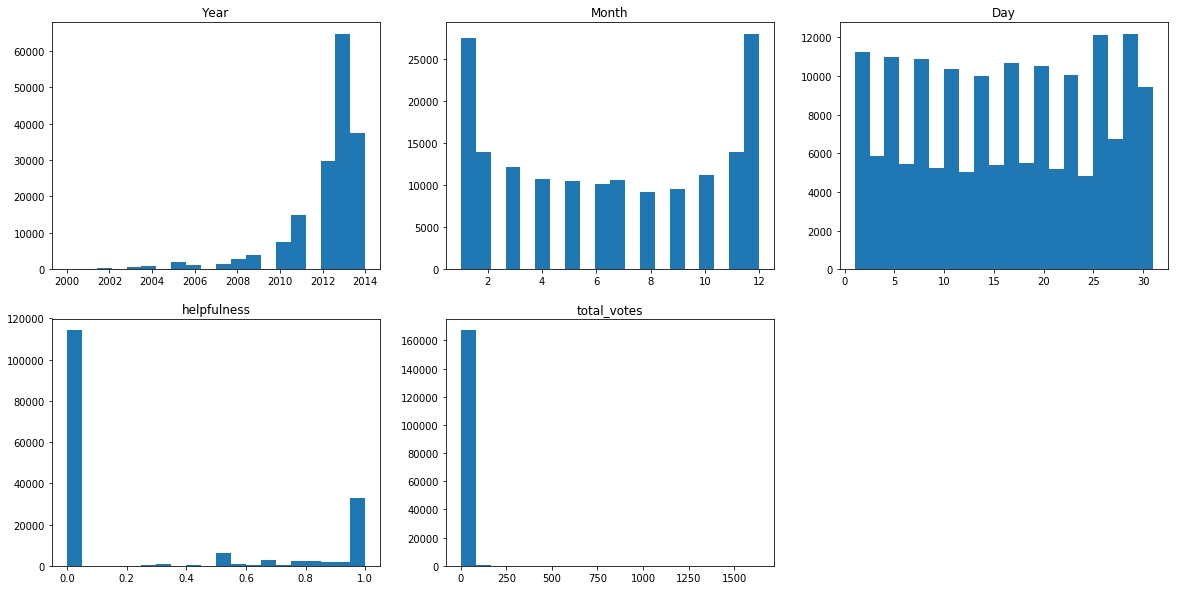

In [6]:
print(len(df['asin'].unique()), 'unique products')
print(len(df['reviewerID'].unique()), 'unique reviewers')

cols_to_inspect = ['Year', 'Month', 'Day', 'helpfulness', 'total_votes']

def create_hists(df):
    plt.figure(figsize=(20,10))

    for idx, col in enumerate(cols_to_inspect):
        plt.subplot(2, 3, idx + 1)
        plt.hist(df[col], bins=20)
        plt.title(col)

    plt.show()

create_hists(df)

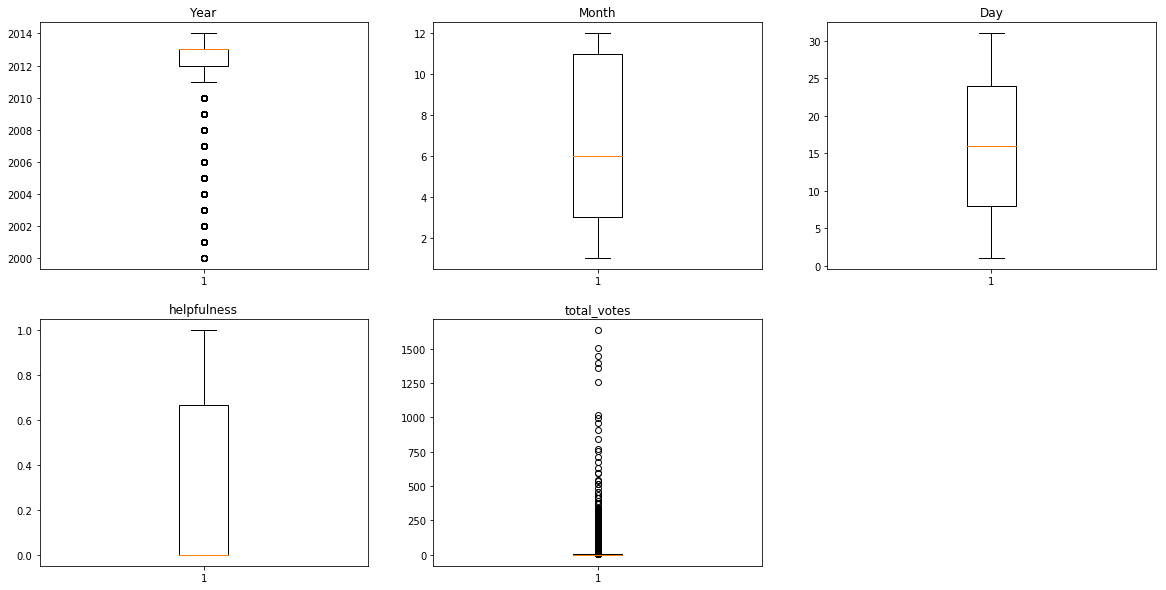

In [7]:
def create_boxplots(df):
    plt.figure(figsize=(20,10))

    for idx, col in enumerate(cols_to_inspect):
        plt.subplot(2, 3, idx + 1)
        plt.boxplot(df[col])
        plt.title(col)

    plt.show()

create_boxplots(df)

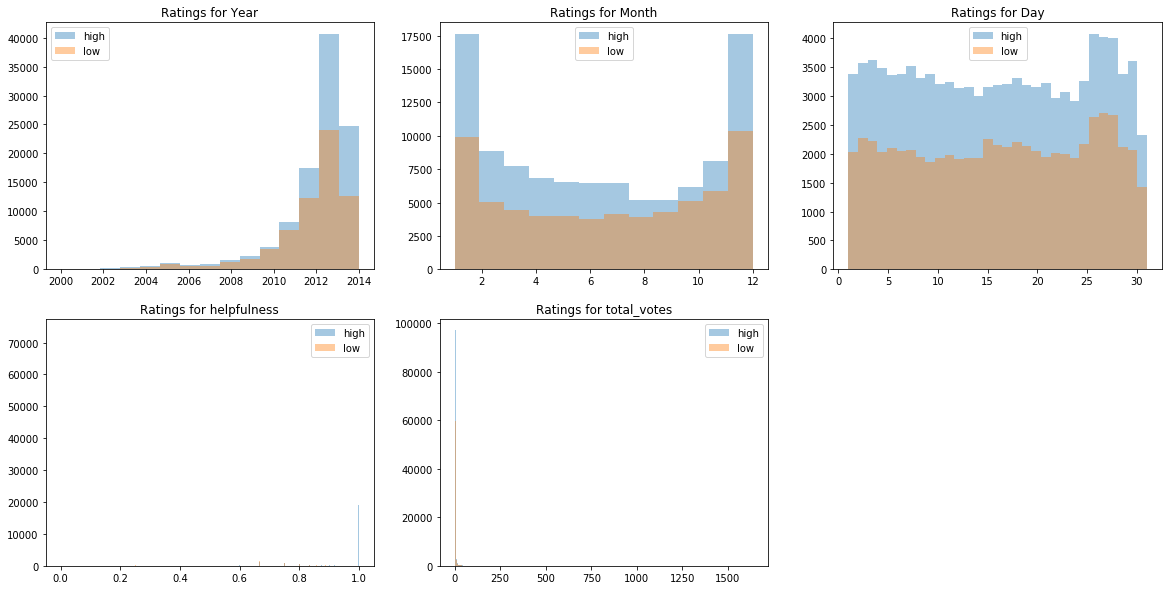

In [8]:
def create_rating_hists(df):
    plt.figure(figsize=(20,10))

    for idx, col in enumerate(cols_to_inspect):
        plt.subplot(math.ceil(len(cols_to_inspect) / 3), 3, idx + 1)
        for rating in sorted(df['overall'].unique()):
            df_for_rating = df[df['overall'] == rating]
            plt.hist(df_for_rating[col], bins=len(df_for_rating[col].unique()), histtype='bar', alpha=0.4, label=str(rating))
        plt.legend()
        plt.title('Ratings for ' + col)

    plt.show()

create_rating_hists(df)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


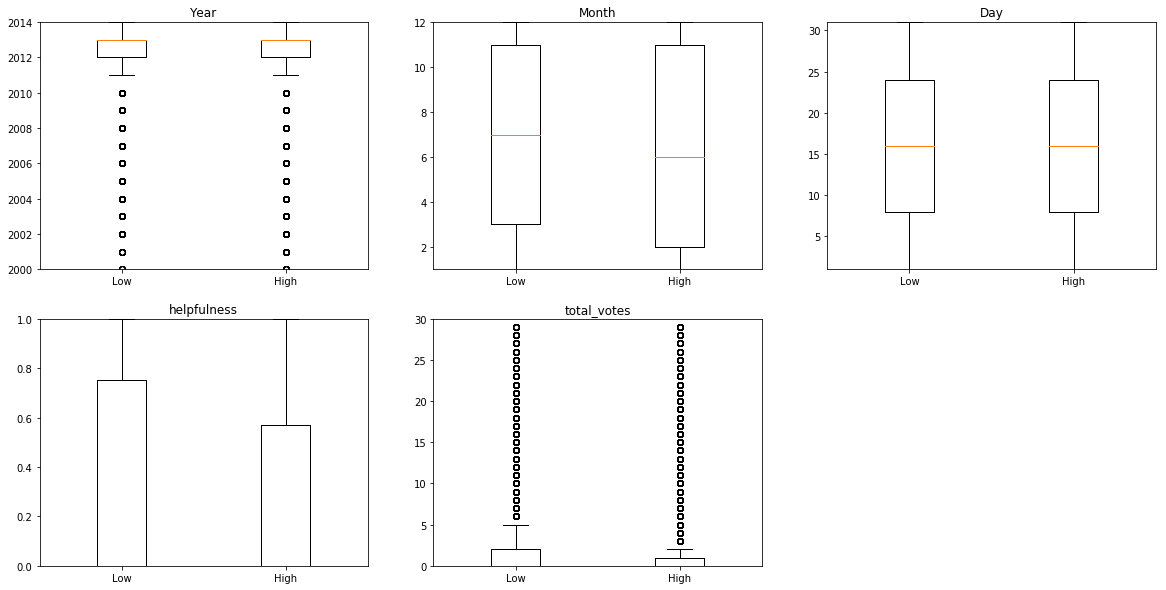

In [9]:
def create_rating_boxplots(df):
    low_stars = df[df['overall'] == 'low']
    high_stars = df[df['overall'] == 'high']

    plt.figure(figsize=(20,10))

    for idx, col in enumerate(cols_to_inspect):
        if col == 'total_votes':
            less_30_votes = df['total_votes'] < 30
            low_stars = low_stars[less_30_votes]
            high_stars = high_stars[less_30_votes]

        plt.subplot(math.ceil(len(cols_to_inspect) / 3), 3, idx + 1)
        groups = [[low_stars[col]], [high_stars[col]]]

        for idx2, group in enumerate(groups):
            plt.boxplot(group, positions=[idx2 * 2 + 1], widths=0.6)

            ylim_max = 30 if col == 'total_votes' else np.max(df[col])
            plt.xlim(0,len(groups) * 2)
            plt.ylim(np.min(df[col]), ylim_max)
            plt.xticks([1, 3], ['Low', 'High'])
            plt.title(col)

    plt.show()

create_rating_boxplots(df)

## Feature Engineering

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

X = df.drop(columns=['overall', 'reviewText', 'summary', 'asin', 'reviewerID'])
Y = df['overall']

vanilla = linear_model.LogisticRegression(penalty='l2',C=1e42)
vanilla.fit(X, Y)
vanilla_score_training = vanilla.score(X, Y)

cross_val_score(vanilla, X, Y, cv=5)

array([0.63412888, 0.63293556, 0.62677884, 0.62489931, 0.62143859])

~61% is a very poor score, as 61% of my reviews are 5-star reviews, and I would be able to get this model's accuracy score while blindly guessing 5 each time. Time to engineer some features.

In [11]:
df['reviewText_len'] = df['reviewText'].str.split().apply(len)
df.head()

,asin,overall,reviewText,reviewerID,summary,Year,Month,Day,helpful_votes,unhelpful_votes,total_votes,helpfulness,reviewText_len
0,0439893577,high,I like the item pricing. My granddaughter want...,A1VXOAVRGKGEAK,Magnetic board,2014,1,29,0,0,0,0.0,20
1,0439893577,low,Love the magnet easel... great for moving to d...,A8R62G708TSCM,it works pretty good for moving to different a...,2014,3,28,1,0,1,1.0,22
2,0439893577,high,Both sides are magnetic. A real plus when you...,A21KH420DK0ICA,love this!,2013,1,28,1,0,1,1.0,76
3,0439893577,high,Bought one a few years ago for my daughter and...,AR29QK6HPFYZ4,Daughters love it,2014,2,8,0,0,0,0.0,31
4,0439893577,low,I have a stainless steel refrigerator therefor...,ACCH8EOML6FN5,Great to have so he can play with his alphabet...,2014,5,5,1,0,1,1.0,47


In [12]:
low_stars = df[df['overall'] == 'low']
high_stars = df[df['overall'] == 'high']

# all_reviews_text = df['reviewText'].str.cat(sep=' ')
# TODO: CHANGE FROM 10000 TO 100000
low_stars_text = low_stars['reviewText'].str.cat(sep=' ')[:10000]
high_stars_text = high_stars['reviewText'].str.cat(sep=' ')[:10000]

nlp = spacy.load('en')
all_docs = [nlp(text) for text in [low_stars_text, high_stars_text]]

In [13]:
# from spacy.attrs import LEMMA
# all_docs[0].to_array([LEMMA])

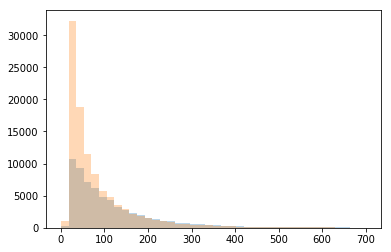

In [14]:
plt.hist(low_stars[low_stars['reviewText_len'] < 700]['reviewText_len'], alpha=0.3, bins=40)
plt.hist(high_stars[high_stars['reviewText_len'] < 700]['reviewText_len'], alpha=0.3, bins=40)
plt.show()

In [15]:
def word_frequencies(doc):
    words = []
    for token in doc:
        if not token.is_punct and not nlp(token.lower_)[0].is_stop and not token.lemma_ in ['game', 'toy', 'board']:
            words.append(token.lemma_)
    return Counter(words).most_common(20)

all_frequencies = [word_frequencies(doc) for doc in all_docs]
all_frequencies[0]

[(' ', 31),
 ('magnet', 16),
 ('book', 14),
 ('good', 13),
 ('not', 13),
 ('be', 11),
 ('great', 10),
 ('magnetic', 10),
 ('like', 10),
 ('color', 10),
 ('love', 9),
 ('use', 9),
 ('cute', 9),
 ('animal', 9),
 ('play', 8),
 ('old', 8),
 ('work', 7),
 ('daughter', 7),
 ('design', 7),
 ('page', 7)]

In [16]:
# print(stopwords.words('english'))
all_common = list(map(lambda x: [pair[0] for pair in x], all_frequencies))
unique_to_low = set(all_common[0]) - set(all_common[1])
unique_to_high = set(all_common[1]) - set(all_common[0])

print('Unique to Low:', unique_to_low)
print('Unique to High:', unique_to_high)

Unique to Low: {'good', 'magnet', 'work', 'cute', 'daughter', 'play', 'animal', 'magnetic'}
Unique to High: {'child', 'year', 'nice', 'buy', 'kid', 'sticker', 'llama', 'letter'}


In [17]:
# TODO: just added more features, but not more strategic
# new_word_features = list(set(list(unique_to_low) + list(unique_to_high)))
new_word_features = list(set(all_common[0])) + list(set(all_common[1]))

# TAKES TOO LONG
# def get_word_count(word, reviewText):
#     count = 0
#     for token in nlp(reviewText):
#         if token.lemma_ == word:
#             count += 1
#     return count

for word in new_word_features:
    df[word] = [1 if word in reviewText else 0 for reviewText in df['reviewText']]

df.head()

,asin,overall,reviewText,reviewerID,summary,Year,Month,Day,helpful_votes,unhelpful_votes,...,old,magnetic,child,year,nice,buy,kid,llama,sticker,letter
0,0439893577,high,I like the item pricing. My granddaughter want...,A1VXOAVRGKGEAK,Magnetic board,2014,1,29,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0439893577,low,Love the magnet easel... great for moving to d...,A8R62G708TSCM,it works pretty good for moving to different a...,2014,3,28,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0439893577,high,Both sides are magnetic. A real plus when you...,A21KH420DK0ICA,love this!,2013,1,28,1,0,...,1,1,1,1,0,0,1,0,0,1
3,0439893577,high,Bought one a few years ago for my daughter and...,AR29QK6HPFYZ4,Daughters love it,2014,2,8,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0439893577,low,I have a stainless steel refrigerator therefor...,ACCH8EOML6FN5,Great to have so he can play with his alphabet...,2014,5,5,1,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df.drop(columns=['overall', 'reviewText', 'summary', 'asin', 'reviewerID']).columns

Index(['Year', 'Month', 'Day', 'helpful_votes', 'unhelpful_votes',
       'total_votes', 'helpfulness', 'reviewText_len', 'good', 'magnet',
       'color', 'be', 'love', 'cute', 'work', 'use', 'daughter', 'page',
       'play', 'great', 'animal', 'like', ' ', 'book', 'design', 'not', 'old',
       'magnetic', 'child', 'year', 'nice', 'buy', 'kid', 'llama', 'sticker',
       'letter'],
      dtype='object')

In [19]:
X = df.drop(columns=['overall', 'reviewText', 'summary', 'asin', 'reviewerID'])
Y = df['overall']

vanilla = linear_model.LogisticRegression(penalty='l2',C=1e42)
vanilla.fit(X, Y)
vanilla_score_training = vanilla.score(X, Y)

cross_val_score(vanilla, X, Y, cv=5)

array([0.66169451, 0.67040573, 0.6744533 , 0.6665175 , 0.67806319])

In [23]:
bnb = BernoulliNB()
bnb.fit(X, Y)
cross_val_score(bnb, X, Y, cv=5)

array([0.62652148, 0.64564439, 0.65091441, 0.64441063, 0.65413646])